## Name: Joshua Wacks<br />Student Number: 2143116<br />Project Choice: Project 1 – Spam Classification Using Naïve Baye

In [1]:
import warnings
warnings.filterwarnings("ignore")

!pip install PrettyTable
!pip install seaborn
!pip install collections

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [2]:

#important library to organise output

import pandas as pd
import string
import re
from nltk.corpus import stopwords
import numpy as np
from collections import Counter
import sklearn
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Preprocess the data, tokenize the text, and get a list of words for each sentence. [10 marks]

In [3]:
stopwords_english = stopwords.words('english')

In [4]:
# with open('currencies.txt',encoding="utf8") as file:
# 	print(file.read().splitlines())

TODO Take a look at stemming or lemming the words or just using NLTK preprocessing

TODO Implement technique to not take out currencies for improved model

In [5]:
def preprocess_data(table):
	#We remove all \r,\n tokens from the string
	table['text'] = table.text.apply(lambda x: re.sub(r'\r','',x))
	table['text'] = table.text.apply(lambda x: re.sub(r'\n',' ',x))
 
	#Removing the word subject from the string as all the emails have it
	table['text'] = table.text.apply(lambda x: re.sub(r'Subject:','',x))
 
	#Removing all punctuation
	table['text'] = table.text.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
 
	#Removing all spaces and empty strings from after split
	table['text'] = table.text.apply(lambda x: list(filter(None,x.split(' '))))
 
	#Removing stop words,case folding 
	table['text'] = table.text.apply(lambda x: [(word.lower()) for word in x if word not in stopwords_english])
	
	
	
	

In [6]:
train_tokenized = pd.read_csv('train.csv')
preprocess_data(train_tokenized)
train_tokenized.head()

,text,label
0,"[thank, ami, daren, wanted, say, thanks, great...",0
1,"[spot, firm, tickets, vance, following, nomina...",0
2,"[software, microsoft, windows, xp, professiozn...",1
3,"[noms, actual, flow, 2, 27, agree, forwarded, ...",0
4,"[superb, ftware, youll, discover, awesome, sof...",1


In [7]:
val_tokenized = pd.read_csv('val.csv')
preprocess_data(val_tokenized)
val_tokenized.head()

,text,label
0,"[viagra, cialis, levitra, ambien, valium, xana...",1
1,"[october, wellhead, vance, deal, 420022, creat...",0
2,"[fw, danger, phenylpropanolamine, original, me...",0
3,"[chea, p, software, looking, extremely, cheap,...",1
4,"[mother, may, find, remove, larvae, adolescent...",1


In [8]:
test_tokenized = pd.read_csv('test.csv')
preprocess_data(test_tokenized)
test_tokenized.head()

,text,label
0,"[prc, meeting, agenda, recap, clarify, discuss...",0
1,"[enron, actuals, april, 4, 2001, estimated, ac...",0
2,"[february, surveys, hello, starting, prepare, ...",0
3,"[today, orchard, guei, republic, cote, ivoire,...",1
4,"[8, 00, assignment, termination, expiration, r...",0


In [9]:
print(F'Training Size: {len(train_tokenized)}\nValidation Size: {len(val_tokenized)}\nTest Size: {len(test_tokenized)}\n')

Training Size: 3102
Validation Size: 1035
Test Size: 1034



### 2. Train a standard Naive Bayes model. Call this Model1 [10 marks].

#### Extractring a Vocabulary

In [10]:
def get_vocabulary(data):
	all_text = data.explode('text')['text']
	vocab = set(all_text)
	return vocab

#### Calculating the prior for both the positive and negative classes

In [11]:
def calculate_priors(data):
	
	num_spam = len(train_tokenized[train_tokenized['label']  == 1])
	num_not_spam = len(train_tokenized[train_tokenized['label']  == 0])
	num_total = num_spam + num_not_spam

	prior_spam = num_spam / num_total
	prior_not_spam = num_not_spam / num_total
	
	
	return prior_spam, prior_not_spam

#### Calculating Word Frequencies

In [12]:
def count_word_frequency(data):
	word_freq = dict()

	for i in [0,1]:
		class_data = data[data['label']  == i]
		class_data = data[data['label']  == i]
		all_text = class_data.explode('text')['text']
		temp_dict = dict(Counter(all_text))
  
		keys = [(k,i) for k in temp_dict.keys()]

		dict_new = dict(zip(keys,temp_dict.values()))
		word_freq.update(dict_new)
	
	return word_freq
  
	


#### Calculating and storing the probabilities of all words

In [13]:
def calc_prob(freq_dicts,vocab,k=1):
	prob_dict = {}
    
	vocab_length = len(vocab)
	spam_vocab_length = len(get_vocabulary(train_tokenized[train_tokenized['label']  == 1]))
	not_spam_vocab_length = len(get_vocabulary(train_tokenized[train_tokenized['label']  == 0]))
	
	for word in vocab:
		my_key = tuple([word,0])
		if my_key in freq_dicts:
			prob_dict[my_key] = ( freq_dicts[my_key] + k)/(not_spam_vocab_length + k*vocab_length)
		else:
			prob_dict[my_key] = k/(not_spam_vocab_length + k*vocab_length)

		my_key = tuple([word,1])
		if my_key in freq_dicts:
			prob_dict[my_key] = (freq_dicts[my_key] + k)/(spam_vocab_length + k*vocab_length)
		else:
			prob_dict[my_key] = k/(spam_vocab_length + k*vocab_length)
		
	return prob_dict

#### Calculating the probability that a given email is spam or not

In [14]:
def predict_class(email, prior_pos, prior_neg, prob_dict, vocab):
	# YOUR CODE HERE
	prob_pos = np.log(prior_pos)
	prob_neg = np.log(prior_neg)
	
	for word in email:
		if word in vocab:
			my_key = tuple([word,1])
			prob_pos = prob_pos + np.log(prob_dict[my_key])
   
			my_key = tuple([word,0])
			prob_neg = prob_neg + np.log(prob_dict[my_key])
	return prob_pos, prob_neg

#### Building a model given a set of features

In [15]:
class Modal:
    
	def __init__(self,features):
		self.vocab = get_vocabulary(features)
		
		self.prior_spam, self.prior_not_spam = calculate_priors(features)
	
		self.word_freq = count_word_frequency(features)
	
		self.prob_dict = calc_prob(self.word_freq,self.vocab)
  
	def modal_info(self):
		print('Vocabulary: ',list(self.vocab)[:5])
		print('Priors: ',self.prior_spam, self.prior_not_spam)
		print('Word Frequncies: ',list(self.word_freq.keys())[:5],list(self.word_freq.values())[:5])
		print('Word Probabilities: ',list(self.prob_dict.keys())[:5],list(self.prob_dict.values())[:5])
  
	def predict_class(self,email):
		prob_pos = np.log(self.prior_spam)
		prob_neg = np.log(self.prior_not_spam)
  
		for word in email:
			if word in self.vocab:
				my_key = tuple([word,1])
				prob_pos = prob_pos + np.log(self.prob_dict[my_key])
	
				my_key = tuple([word,0])
				prob_neg = prob_neg + np.log(self.prob_dict[my_key])
		return prob_pos, prob_neg
  

### 2. Train a standard Naive Bayes model. Call this Model1 [10 marks].

In [16]:
M1 = Modal(train_tokenized)

### 3. Train 4 additional Naïve Bayes models with the following variations: 

#### a. Use only the 10 most frequent words as features. Call this Model2 [10 marks]

In [17]:
all_words = train_tokenized.explode('text')['text']
word_count = dict(Counter(all_words))
word_count_sorted =  dict(sorted(word_count.items(), key=lambda item: item[1],reverse=True))
ten_most_frequent_words = list(word_count_sorted.keys())[:10]
print("The 10 most frquent words are: ",ten_most_frequent_words)

The 10 most frquent words are:  ['ect', 'hou', 'enron', '2000', 'com', 'please', 'gas', 'deal', 'subject', '3']


#### Changing the data to only include these words

In [18]:
train_tokenized_ten_frequent = train_tokenized.copy()
train_tokenized_ten_frequent['text'] = train_tokenized_ten_frequent.text.apply(lambda x: [word for word in x if word in ten_most_frequent_words])

M2 = Modal(train_tokenized_ten_frequent)


#### b. Use only the 100 most frequent words as features. Call this Model3 [10 marks].

In [19]:
hundred_most_frequent_words = list(word_count_sorted.keys())[:100]
print("The 100 most frquent words are: ",hundred_most_frequent_words)


The 100 most frquent words are:  ['ect', 'hou', 'enron', '2000', 'com', 'please', 'gas', 'deal', 'subject', '3', '1', 'meter', 'hpl', 'cc', '2', '00', 'pm', '000', '10', 'e', '2001', 'daren', 'thanks', '01', 'corp', 'know', '5', '4', 'new', 'need', '11', '12', 'j', '0', 'may', 'mmbtu', 'forwarded', 'see', 'get', 'http', 'company', 'price', '03', 'let', 'information', 'farmer', 'attached', '99', 'l', '7', 'would', 'xls', '6', 'day', 'th', '02', 'contract', '9', 'time', 'one', 'us', 'robert', 'message', '8', '30', '04', '05', 'volume', 'mail', 'month', '08', 'net', 'volumes', '20', 'p', 'deals', 'sitara', '15', 'texas', '09', 'email', 'questions', 'ena', 'nom', 'energy', 'also', 'sent', 'www', 'file', 'flow', 'change', 'x', 'like', 'pec', 'call', 'production', 'b', 'bob', '31', '06']


In [20]:
train_tokenized_hundred_frequent = train_tokenized.copy()
train_tokenized_hundred_frequent['text'] = train_tokenized_hundred_frequent.text.apply(lambda x: [word for word in x if word in hundred_most_frequent_words])

M3 = Modal(train_tokenized_hundred_frequent)

#### c. Remove the 100 most frequent words from the features. Call this Model4 [10 marks]

In [21]:
train_tokenized_not_hundred_frequent = train_tokenized.copy()
train_tokenized_not_hundred_frequent['text'] = train_tokenized_not_hundred_frequent.text.apply(lambda x: [word for word in x if word not in hundred_most_frequent_words])

M4 = Modal(train_tokenized_not_hundred_frequent)

#### d. Use only the subject line (see the data) as the feature set. Call this Model5 [10 marks]

TODO Unsure if I should remove stop words here

In [22]:

def preprocess_data_only_subject(table):
	#We remove all \r,\n tokens from the string
	
	table['text'] = table.text.apply(lambda x: x[x.index(':')+1:x.index('\n')]) # Getting only the subject first
	
	table['text'] = table.text.apply(lambda x: re.sub(r'\r','',x))
	table['text'] = table.text.apply(lambda x: re.sub(r'\n',' ',x))
 
	table['text'] = table.text.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
 
	table['text'] = table.text.apply(lambda x: list(filter(None,x.split(' '))))
	table['text'] = table.text.apply(lambda x: [(word.lower()) for word in x ])
 
	# table['text'] = table.text.apply(lambda x: [(word.lower()) for word in x if word not in stopwords_english])
	
	
	
	

In [23]:
train_subject_only = pd.read_csv('train.csv')
preprocess_data_only_subject(train_subject_only)
train_subject_only.head()

,text,label
0,"[thank, you]",0
1,"[spot, or, firm, tickets]",0
2,[software],1
3,"[noms, actual, flow, for, 2, 27]",0
4,"[superb, so, ftware]",1


In [24]:
M5 = Modal(train_subject_only)

## 4. Evaluate the performance of the first model and all 4 variations using the validation set. 


### a. Calculate the evaluation metrics [10 marks].


In [25]:
tokenized_pred = val_tokenized.copy()
tokenized_pred['predicted_label'] = tokenized_pred.text.apply(lambda x: 1 if M2.predict_class(x)[0] > M2.predict_class(x)[1] else 0)


In [26]:
tokenized_pred[['label','predicted_label']]

,label,predicted_label
0,1,0
1,0,0
2,0,0
3,1,0
4,1,0
...,...,...
1030,0,0
1031,0,0
1032,0,0
1033,1,0


In [27]:
len(tokenized_pred[(tokenized_pred['label'] == tokenized_pred['predicted_label']) & (tokenized_pred['label'] == 1)])


0

In [30]:
def show_confu_matrix(name,modal,data):
	tokenized_pred = data.copy()
	tokenized_pred['predicted_label'] = tokenized_pred.text.apply(lambda x: 1 if modal.predict_class(x)[0] > modal.predict_class(x)[1] else 0)
	cf_matrix = sklearn.metrics.confusion_matrix(tokenized_pred['label'],tokenized_pred['predicted_label'])
 
	g = sns.heatmap(cf_matrix,annot=True, fmt=".1f")
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.title(F'The confusion matrix for modal {name}')
	plt.show()
	
def eval_model(modal,data):
	tokenized_pred = data.copy()
	tokenized_pred['predicted_label'] = tokenized_pred.text.apply(lambda x: 1 if modal.predict_class(x)[0] > modal.predict_class(x)[1] else 0)
 
	table = PrettyTable()
	table.field_names = ['Metric','Value']
	table.add_row(['Accuracy',sklearn.metrics.accuracy_score(tokenized_pred['label'],tokenized_pred['predicted_label'])])
	table.add_row(['F1 Score',sklearn.metrics.f1_score(tokenized_pred['label'],tokenized_pred['predicted_label'])])
	table.add_row(['Precision',sklearn.metrics.precision_score(tokenized_pred['label'],tokenized_pred['predicted_label'])])
	table.add_row(['Recall',sklearn.metrics.recall_score(tokenized_pred['label'],tokenized_pred['predicted_label'])])

	return table	

def compare_all_modals(modals,names,data):
	table = PrettyTable()
	table.field_names = ['Modal','Accuracy','F1 Score','Precision','Recall']
	for name,modal in zip(names,modals):
		tokenized_pred = data.copy()
		tokenized_pred['predicted_label'] = tokenized_pred.text.apply(lambda x: 1 if modal.predict_class(x)[0] > modal.predict_class(x)[1] else 0)
		table.add_row([name,sklearn.metrics.accuracy_score(tokenized_pred['label'],tokenized_pred['predicted_label']),
				 sklearn.metrics.f1_score(tokenized_pred['label'],tokenized_pred['predicted_label']),
				 sklearn.metrics.precision_score(tokenized_pred['label'],tokenized_pred['predicted_label']),
				 sklearn.metrics.recall_score(tokenized_pred['label'],tokenized_pred['predicted_label'])
				 ])
  
	return table

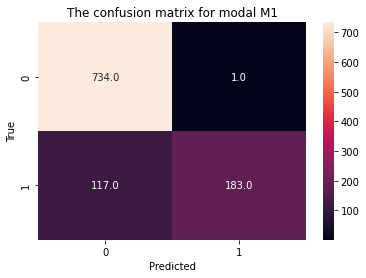

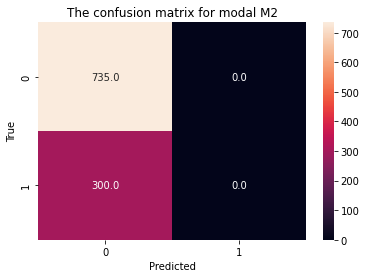

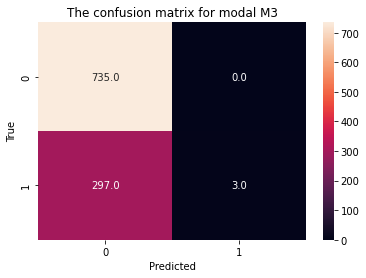

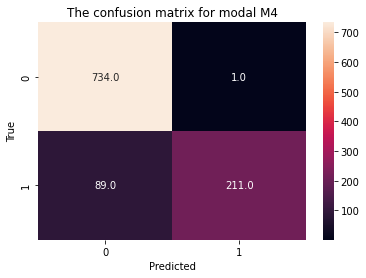

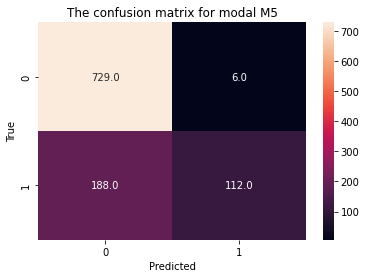

In [37]:
modals = [M1,M2,M3,M4,M5]
names = ['M1','M2','M3','M4','M5']

for name,modal in zip(names,modals):
	# print(F'\n\nThe Confusion Matrix for modal {name}\n')
	show_confu_matrix(name,modal,val_tokenized)

# for name,modal in zip(names,modals):

# 	table = eval_model(modal,val_tokenized)
# 	print(F'\n\nThe results for modal {name}\n',table)


We also take a look at the confusion matrix of each modal to validify results.

### b. Compare all 5 models [5 marks].


In [39]:
table = compare_all_modals(modals,names,val_tokenized)
print('The table below compares all the modals using the validation dataset\n')
print(table)

The table below compares all the modals using the validation dataset

+-------+--------------------+----------------------+--------------------+---------------------+
| Modal |      Accuracy      |       F1 Score       |     Precision      |        Recall       |
+-------+--------------------+----------------------+--------------------+---------------------+
|   M1  | 0.8859903381642512 |  0.756198347107438   | 0.9945652173913043 |         0.61        |
|   M2  | 0.7101449275362319 |         0.0          |        0.0         |         0.0         |
|   M3  | 0.7130434782608696 | 0.019801980198019802 |        1.0         |         0.01        |
|   M4  | 0.9130434782608695 |      0.82421875      | 0.9952830188679245 |  0.7033333333333334 |
|   M5  |  0.81256038647343  |  0.5358851674641149  | 0.9491525423728814 | 0.37333333333333335 |
+-------+--------------------+----------------------+--------------------+---------------------+


As can be seen from the table above all the modals have accuracies above 70%, however once we have taken a look at the F1, prediction and recall scores we realise that this accuracy is midleading. Modals M2 and M3, do not perform well with regards to F1, prediction and recall scores. This is because when we only look at the 10 or 100 most frequent words some emails do not have any words when they are classified. When further analysis is peformed on these results,  a possible reason that modals M2 and M3 do not perform well is because the train dataset is bias to non-spam examples(70% of the emails are not-spam while 30% are spam), thus when we only look at the 10 or 100 most frequent words of the vocabulary it is likely that these words came from the not-spam emails, leaving many of the spam emails without any words. 

### c. Make a recommendation about which model to use with reasons. [5 marks]


I would recommend the use of modal M4 as it achieved the best results in every metric and would be able to generalise best out of all the modals as it did not rely on the frequent words and achieved the highest recall score which is the most important metric here as it would not be that bad if a normal email got flagged as spam(the user would just verify this) but rather it would be a lot worse if spam email did not get flagged and went through undetected as a normal email and caused a lot of harm to the users computer.

## 5. Now, evaluate all the models with the test set


### a. Calculate the evaluation metrics [10 marks].

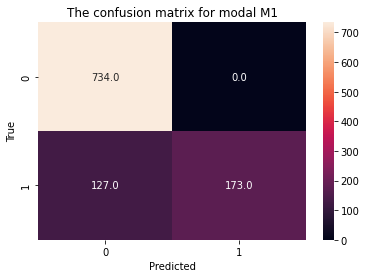

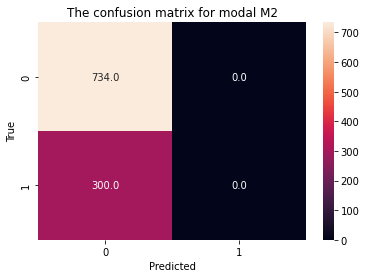

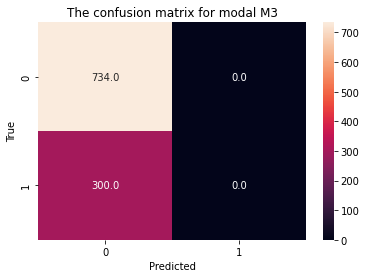

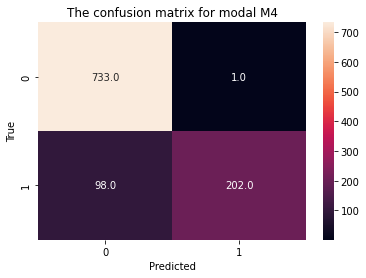

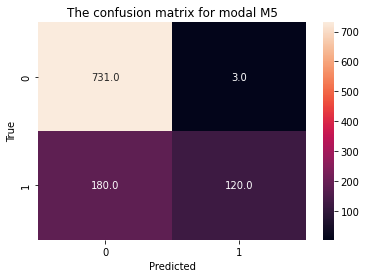

In [38]:
for name,modal in zip(names,modals):
	show_confu_matrix(name,modal,test_tokenized)

In [41]:
table = compare_all_modals(modals,names,test_tokenized)
print('The table below compares all the modals using the test dataset\n')
print(table)

The table below compares all the modals using the test dataset

+-------+--------------------+--------------------+--------------------+--------------------+
| Modal |      Accuracy      |      F1 Score      |     Precision      |       Recall       |
+-------+--------------------+--------------------+--------------------+--------------------+
|   M1  | 0.8771760154738878 | 0.7315010570824524 |        1.0         | 0.5766666666666667 |
|   M2  | 0.7098646034816247 |        0.0         |        0.0         |        0.0         |
|   M3  | 0.7098646034816247 |        0.0         |        0.0         |        0.0         |
|   M4  | 0.9042553191489362 | 0.8031809145129225 | 0.9950738916256158 | 0.6733333333333333 |
|   M5  | 0.8230174081237911 | 0.5673758865248227 | 0.975609756097561  |        0.4         |
+-------+--------------------+--------------------+--------------------+--------------------+


### b. Is your recommendation (in 4c above) still is valid? Explain [5 marks]

Yes the recommendation of modal M4 is still valid as it still achieved the best result out of modals M1 to M5 in all the metrics that we tested. However, the recall score has decreased and given the imporatnce of this metric it is vital that we increase it.